# JIRA Delay Analysis - October to November

**Goal**: Identify top 5 and top 10 themes causing delays from October to November using LLM-assisted sentiment analysis

**Approach**:
1. Load and clean JIRA data
2. Filter October issues delayed to November
3. Extract and analyze comments using GPT
4. Cluster themes and identify root causes
5. Generate actionable management insights

## 1. Setup and Imports

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# Add src to path for custom modules
sys.path.append('../src')

# Load environment variables
load_dotenv()

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✅ Environment setup complete")

✅ Environment setup complete


## 2. Load Data

In [ ]:
# Load JIRA CSV data
# Update the filename to match your actual JIRA export
data_path = 'C:\\Users\\Andy\\Desktop\\Text_Analysis\\data\\raw\\JiraComments_FromJql.csv'

# You can obtain this file by exporting issues from JIRA using JQL queries. JIRA uses PAT tokens for authentication, with a Bearer token format. 
# If you need help generating a PAT token, or accesing the JIRA API, please send me an email at orlandoandres.nunezisaac@rochesterregional.org :)

# Check if file exists
if not os.path.exists(data_path):
    print(f"⚠️ File not found: {data_path}")
    print("Please place your JIRA CSV export in the data/raw/ directory")
else:
    df = pd.read_csv(data_path)
    print(f"✅ Loaded {len(df)} records")
    print(f"\nColumns: {list(df.columns)}")
    df.head()

✅ Loaded 241 records

Columns: ['IssueKey', 'CommentId', 'Author', 'AuthorEmail', 'Created', 'Updated', 'Body']


In [3]:
# Data quality check
print("Data Quality Summary:")
print("=" * 50)
print(f"Total records: {len(df)}")
print(f"\nMissing values:\n{df.isnull().sum()}")
print(f"\nData types:\n{df.dtypes}")

Data Quality Summary:
Total records: 241

Missing values:
IssueKey       0
CommentId      0
Author         0
AuthorEmail    0
Created        0
Updated        0
Body           0
dtype: int64

Data types:
IssueKey       object
CommentId       int64
Author         object
AuthorEmail    object
Created        object
Updated        object
Body           object
dtype: object


## 3. Data Preprocessing

In [4]:
# Convert date columns to datetime with timezone awareness
# Adjust column names based on your actual JIRA export
date_columns = ['Created', 'Updated']  # Resolved may not exist in this dataset

for col in date_columns:
    if col in df.columns:
        # First convert to datetime, then localize timezone
        df[col] = pd.to_datetime(df[col], errors='coerce', utc=False)
        # Handle timezone-aware strings
        # Only use .dt accessor if column is datetimelike to avoid AttributeError
        if pd.api.types.is_datetime64_any_dtype(df[col]):
            try:
                if df[col].dt.tz is None:
                    df[col] = df[col].dt.tz_localize('US/Eastern', ambiguous='NaT', nonexistent='NaT')
            except Exception:
                # If localization fails, just proceed with naive timezone
                pass
        print(f"✅ Converted {col} to datetime")
    else:
        print(f"⚠️ Column '{col}' not found")

print("\nDate conversion complete")

✅ Converted Created to datetime
✅ Converted Updated to datetime

Date conversion complete


In [16]:
# Check the date range in the data
print("Date range in data:")
print(f"Earliest Created: {df['Created'].min()}")
print(f"Latest Created: {df['Created'].max()}")
print("\n")

# Filter for October 2025 issues (adjust year based on actual data)
october_start = pd.Timestamp('2025-10-01', tz='UTC').tz_convert('US/Eastern')
october_end = pd.Timestamp('2025-10-31', tz='UTC').tz_convert('US/Eastern')
november_start = pd.Timestamp('2025-11-01', tz='UTC').tz_convert('US/Eastern')

print(f"✅ Found {len(df)} issues from October 2025")
print(f"   (from {df['IssueKey'].nunique()} unique JIRA issues)")
df.head()

Date range in data:
Earliest Created: 2025-09-23 10:30:18.367000-04:00
Latest Created: 2025-11-10 12:51:24.457000-05:00


✅ Found 241 issues from October 2025
   (from 39 unique JIRA issues)


,IssueKey,CommentId,Author,AuthorEmail,Created,Updated,Body
0,SWIFT-7544,55859,Molly Andrasik,molly.andrasik@rochesterregional.org,2025-10-28 11:26:52.037000-04:00,2025-10-28 11:26:52.037000-04:00,This was not ready for PRD by 10/27. Dr. Mullin is targeting 11/6. Adding the November release.
1,SWIFT-7544,56452,Molly Andrasik,molly.andrasik@rochesterregional.org,2025-11-04 12:32:55.637000-05:00,2025-11-04 12:32:55.637000-05:00,[~SMULLIN] and [~T324172] - We were targeting this for 11/6. Is that still the plan?
2,SWIFT-7544,56508,"Mullin, Suzanne",Suzanne.Mullin@rochesterregional.org,2025-11-04 13:19:01.640000-05:00,2025-11-04 13:19:01.640000-05:00,Yes. Working on it now\r\n\r\n
3,SWIFT-7544,56584,Molly Andrasik,molly.andrasik@rochesterregional.org,2025-11-05 11:50:14.713000-05:00,2025-11-05 11:50:14.713000-05:00,CRQ7023685 planned for Maintenance release on 11/6.
4,SWIFT-7543,55787,Molly Andrasik,molly.andrasik@rochesterregional.org,2025-10-28 10:22:16.687000-04:00,2025-10-28 10:22:16.687000-04:00,[~SMULLIN] and [~LYOGIS] was this completed last week? Has it been moved to PRD?


In [6]:
# Extract comments from delayed issues
# Adjust 'Comment' column name to match your data
comment_column = 'Body'

if comment_column in df.columns:
    # Remove null comments
    issues_with_comments = df[df[comment_column].notna()].copy()
    print(f"✅ {len(issues_with_comments)} issues have comments")
    
    # Sample of comments
    print("\nSample comments:")
    for idx, comment in issues_with_comments[comment_column].head(3).items():
        print(f"\n--- Issue {idx} ---")
        print(comment[:200] + "..." if len(str(comment)) > 200 else comment)
else:
    print(f"⚠️ Column '{comment_column}' not found. Available columns: {list(df.columns)}")

✅ 241 issues have comments

Sample comments:

--- Issue 0 ---
This was not ready for PRD by 10/27. Dr. Mullin is targeting 11/6. Adding the November release. 

--- Issue 1 ---
[~SMULLIN] and [~T324172] - We were targeting this for 11/6. Is that still the plan? 

--- Issue 2 ---
Yes.  Working on it now

 


## 4. Data Aggregation Strategy (GROUP BY ISSUEKEY)

**Methodology Section 1.2**: Group comments by IssueKey to reduce API calls from 241 to 39.

This provides:
1. Complete conversational context for the LLM
2. More accurate thematic inference
3. Significant cost reduction

In [17]:
# Import ML libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Group comments by IssueKey and calculate metrics
issue_groups = []

for issue_key, group in issues_with_comments.groupby('IssueKey'):
    # Combine all comments for this issue
    combined_comments = "\n---\n".join(group['Body'].tolist())
    
    # Calculate time metrics
    first_comment_date = group['Created'].min()
    last_comment_date = group['Created'].max()
    days_active = (last_comment_date - first_comment_date).days
    
    # Calculate other metrics
    comment_count = len(group)
    unique_authors = group['Author'].nunique()
    authors_list = ', '.join(group['Author'].unique()[:3])
    
    issue_groups.append({
        'IssueKey': issue_key,
        'combined_comments': combined_comments,
        'comment_count': comment_count,
        'unique_authors': unique_authors,
        'authors_sample': authors_list,
        'first_comment_date': first_comment_date,
        'last_comment_date': last_comment_date,
        'days_active': days_active
    })

issues_df = pd.DataFrame(issue_groups)

print(f"✅ Grouped into {len(issues_df)} IssueKeys for analysis")
print(f"✅ API calls reduced from {len(issues_with_comments)} to {len(issues_df)}")
print(f"\nSample grouped data:")
display(issues_df[['IssueKey', 'comment_count', 'unique_authors', 'days_active']].head(10))

✅ Grouped into 39 IssueKeys for analysis
✅ API calls reduced from 241 to 39

Sample grouped data:


,IssueKey,comment_count,unique_authors,days_active
0,SWIFT-5662,9,5,25
1,SWIFT-6337,6,2,19
2,SWIFT-6889,11,2,22
3,SWIFT-6891,3,2,9
4,SWIFT-6900,1,1,0
5,SWIFT-6906,1,1,0
6,SWIFT-6922,6,3,20
7,SWIFT-6927,5,3,25
8,SWIFT-6928,5,2,18
9,SWIFT-6932,7,4,20


## 5. LLM-Based Theme Extraction

**Methodology Section 1.3**: Analyze each aggregated issue conversation with GPT-4.

Extract:
- Primary delay factors (thematic categories)
- Sentiment indicators
- Root cause attribution
- Structured output in JSON format

In [7]:
# Import custom LLM analyzer
from llm_analyzer import DelayThemeAnalyzer

# Initialize analyzer
analyzer = DelayThemeAnalyzer()

print("✅ LLM analyzer initialized")

✅ LLM analyzer initialized


In [18]:
# Re-run LLM analysis on GROUPED comments (much more efficient!)
delay_themes_grouped = []

print(f"Analyzing {len(issues_df)} IssueKeys...")
print(f"Estimated time: ~{len(issues_df) * 3 / 60:.1f} minutes\n")

for idx, row in tqdm(issues_df.iterrows(), total=len(issues_df), desc="Extracting themes"):
    issue_key = row['IssueKey']
    combined_text = row['combined_comments']
    
    # Get delay theme from GPT (1 call for all comments in this issue)
    theme_result = analyzer.extract_delay_theme(combined_text, issue_key)
    delay_themes_grouped.append(theme_result)

# Convert to DataFrame
themes_grouped_df = pd.DataFrame(delay_themes_grouped)

print(f"\n✅ Analyzed {len(themes_grouped_df)} IssueKeys")
print(f"✅ Extracted {themes_grouped_df['theme'].nunique()} unique themes")
display(themes_grouped_df.head(10))

Analyzing 39 IssueKeys...
Estimated time: ~1.9 minutes



Extracting themes:   0%|          | 0/39 [00:00<?, ?it/s]


✅ Analyzed 39 IssueKeys
✅ Extracted 6 unique themes


,issue_key,theme,sentiment,reasoning,raw_response
0,SWIFT-5662,Communication Gaps,neutral,The delay is primarily due to the need for further discussions and alignment among team members ...,THEME: Communication Gaps\nSENTIMENT: Neutral\nREASONING: The delay is primarily due to the need...
1,SWIFT-6337,Requirements Issues,neutral,The delay was primarily due to the addition of new design items based on an updated policy for 2...,THEME: Requirements Issues\nSENTIMENT: Neutral\nREASONING: The delay was primarily due to the ad...
2,SWIFT-6889,Resource Constraints,negative,"The primary issue causing the delay was the lack of assigned resources to the Design task, as hi...",THEME: Resource Constraints\nSENTIMENT: Negative\nREASONING: The primary issue causing the delay...
3,SWIFT-6891,Requirements Issues,negative,"The comment highlights issues with changing requirements and unclear specifications, leading to ...",THEME: Requirements Issues\nSENTIMENT: Negative\nREASONING: The comment highlights issues with c...
4,SWIFT-6900,Communication Gaps,neutral,"The comment is a follow-up for an update, indicating a lack of prior communication or updates re...",THEME: Communication Gaps\nSENTIMENT: Neutral\nREASONING: The comment is a follow-up for an upda...
5,SWIFT-6906,Dependencies,neutral,"The delay is due to the need for a resource from an external vendor, Cadence, to provide knowled...",THEME: Dependencies\nSENTIMENT: Neutral\nREASONING: The delay is due to the need for a resource ...
6,SWIFT-6922,Dependencies,neutral,"The delay is primarily due to waiting for data entry completion by Stephanie's team, which is a ...",THEME: Dependencies\nSENTIMENT: Neutral\nREASONING: The delay is primarily due to waiting for da...
7,SWIFT-6927,Communication Gaps,neutral,The delay appears to be primarily due to the need to demo the solution to Operations and schedul...,THEME: Communication Gaps\nSENTIMENT: Neutral\nREASONING: The delay appears to be primarily due ...
8,SWIFT-6928,Dependencies,neutral,"The delay is primarily due to waiting for Marketing to coordinate with an external vendor, indic...",THEME: Dependencies\nSENTIMENT: Neutral\nREASONING: The delay is primarily due to waiting for Ma...
9,SWIFT-6932,Dependencies,neutral,"The delay is primarily due to waiting for the completion of dependent tasks by other teams, such...",THEME: Dependencies\nSENTIMENT: Neutral\nREASONING: The delay is primarily due to waiting for th...


In [19]:
# Merge theme results with issue metrics
issues_with_themes = issues_df.merge(
    themes_grouped_df[['issue_key', 'theme', 'sentiment', 'reasoning']],
    left_on='IssueKey',
    right_on='issue_key',
    how='left'
)

issues_with_themes = issues_with_themes.drop(columns=['issue_key'])

print(f"✅ Merged theme data with issue metrics")
display(issues_with_themes[[
    'IssueKey', 'theme', 'sentiment', 'comment_count',
    'days_active', 'unique_authors'
]].head(10))

✅ Merged theme data with issue metrics


,IssueKey,theme,sentiment,comment_count,days_active,unique_authors
0,SWIFT-5662,Communication Gaps,neutral,9,25,5
1,SWIFT-6337,Requirements Issues,neutral,6,19,2
2,SWIFT-6889,Resource Constraints,negative,11,22,2
3,SWIFT-6891,Requirements Issues,negative,3,9,2
4,SWIFT-6900,Communication Gaps,neutral,1,0,1
5,SWIFT-6906,Dependencies,neutral,1,0,1
6,SWIFT-6922,Dependencies,neutral,6,20,3
7,SWIFT-6927,Communication Gaps,neutral,5,25,3
8,SWIFT-6928,Dependencies,neutral,5,18,2
9,SWIFT-6932,Dependencies,neutral,7,20,4


## 6. Post-Processing and Theme Clustering

**Methodology Section 1.4**: Use K-means clustering to group similar themes into 5 major clusters.

This addresses semantic redundancy and consolidates thematically similar delay factors.

In [20]:
# Prepare text for clustering
issues_with_themes['text_for_clustering'] = (
    issues_with_themes['theme'].fillna('Unknown') + ' ' +
    issues_with_themes['reasoning'].fillna('')
)

# Vectorize using TF-IDF
vectorizer = TfidfVectorizer(
    max_features=50,
    stop_words='english',
    ngram_range=(1, 2)
)

X = vectorizer.fit_transform(issues_with_themes['text_for_clustering'])

print(f"✅ Vectorized {X.shape[0]} issues into {X.shape[1]} features")

✅ Vectorized 39 issues into 50 features


In [21]:
# Perform KMeans clustering
n_clusters = 5

kmeans = KMeans(
    n_clusters=n_clusters,
    random_state=42,
    n_init=10,
    max_iter=300
)

cluster_labels = kmeans.fit_predict(X)
issues_with_themes['cluster'] = cluster_labels

print(f"✅ Clustered themes into {n_clusters} groups")
print(f"\nCluster distribution:")
print(issues_with_themes['cluster'].value_counts().sort_index())

✅ Clustered themes into 5 groups

Cluster distribution:
cluster
0     5
1    12
2     4
3    14
4     4
Name: count, dtype: int64


In [22]:
# Generate cluster names
cluster_names = {}

for cluster_id in range(n_clusters):
    cluster_issues = issues_with_themes[issues_with_themes['cluster'] == cluster_id]
    top_theme = cluster_issues['theme'].value_counts().index[0]
    count = len(cluster_issues)
    
    cluster_names[cluster_id] = f"Cluster {cluster_id + 1}: {top_theme} ({count} issues)"
    
    print(f"\n{cluster_names[cluster_id]}")
    print(f"  Top themes:")
    for theme, cnt in cluster_issues['theme'].value_counts().head(3).items():
        print(f"    - {theme}: {cnt}")

issues_with_themes['cluster_name'] = issues_with_themes['cluster'].map(cluster_names)


Cluster 1: Resource Constraints (5 issues)
  Top themes:
    - Resource Constraints: 3
    - Dependencies: 2

Cluster 2: Communication Gaps (12 issues)
  Top themes:
    - Communication Gaps: 12

Cluster 3: Dependencies (4 issues)
  Top themes:
    - Dependencies: 4

Cluster 4: Requirements Issues (14 issues)
  Top themes:
    - Requirements Issues: 13
    - Environment Issues: 1

Cluster 5: Process Issues (4 issues)
  Top themes:
    - Process Issues: 4


## 7. COMPREHENSIVE REPORTING


In [25]:
# Create comprehensive report
comprehensive_report = issues_with_themes[[
    'IssueKey',
    'cluster',
    'cluster_name',
    'theme',
    'sentiment',
    'days_active',
    'comment_count',
    'unique_authors',
    'authors_sample',
    'first_comment_date',
    'last_comment_date',
    'reasoning'
]].copy()

comprehensive_report = comprehensive_report.sort_values(
    ['cluster', 'days_active'],
    ascending=[True, False]
)

comprehensive_report.to_csv('../reports/comprehensive_delay_analysis.csv', index=False)

print("✅ Saved comprehensive report")
print(f"\nReport preview:")
display(comprehensive_report.head(15))

✅ Saved comprehensive report

Report preview:


,IssueKey,cluster,cluster_name,theme,sentiment,days_active,comment_count,unique_authors,authors_sample,first_comment_date,last_comment_date,reasoning
14,SWIFT-6981,0,Cluster 1: Resource Constraints (5 issues),Resource Constraints,neutral,28,7,2,"Pearlie Petty, Molly Andrasik",2025-10-03 11:01:55.467000-04:00,2025-10-31 15:10:09.903000-04:00,The delay was primarily due to waiting for additional resources from the Orders Team to modify t...
2,SWIFT-6889,0,Cluster 1: Resource Constraints (5 issues),Resource Constraints,negative,22,11,2,"Molly Andrasik, Pearlie Petty",2025-10-07 12:18:41.130000-04:00,2025-10-30 08:30:37.313000-04:00,"The primary issue causing the delay was the lack of assigned resources to the Design task, as hi..."
6,SWIFT-6922,0,Cluster 1: Resource Constraints (5 issues),Dependencies,neutral,20,6,3,"Erik Jacob, Chris O'Brien, Molly Andrasik",2025-10-01 09:51:12.407000-04:00,2025-10-22 08:51:21.910000-04:00,"The delay is primarily due to waiting for data entry completion by Stephanie's team, which is a ..."
9,SWIFT-6932,0,Cluster 1: Resource Constraints (5 issues),Dependencies,neutral,20,7,4,"Molly Andrasik, Valerie Lonville, Yaseen, Ahmad",2025-10-14 17:12:46.417000-04:00,2025-11-04 13:38:05.663000-05:00,"The delay is primarily due to waiting for the completion of dependent tasks by other teams, such..."
29,SWIFT-7204,0,Cluster 1: Resource Constraints (5 issues),Resource Constraints,neutral,0,1,1,Molly Andrasik,2025-10-22 08:41:55.747000-04:00,2025-10-22 08:41:55.747000-04:00,The delay is due to the unavailability of the internal resource needed to review a billing issue...
31,SWIFT-7299,1,Cluster 2: Communication Gaps (12 issues),Communication Gaps,neutral,34,7,3,"Molly Andrasik, Tamer Salhab Altamimi, Nolan, Megan",2025-10-06 17:13:04.437000-04:00,2025-11-10 12:51:24.457000-05:00,The delay is primarily due to coordination and confirmation issues among team members regarding ...
25,SWIFT-7084,1,Cluster 2: Communication Gaps (12 issues),Communication Gaps,neutral,28,3,2,"Molly Andrasik, Pearlie Petty",2025-10-06 09:52:25.817000-04:00,2025-11-03 18:54:26.973000-05:00,The comment highlights issues related to misalignment and lack of updates on the status of vario...
23,SWIFT-7075,1,Cluster 2: Communication Gaps (12 issues),Communication Gaps,neutral,27,20,7,"Molly Andrasik, Erik Jacob, Paul Cabral",2025-10-06 09:53:08.207000-04:00,2025-11-03 08:42:49.197000-05:00,"The comment indicates a need for status updates, clarification on plans, and coordination among ..."
0,SWIFT-5662,1,Cluster 2: Communication Gaps (12 issues),Communication Gaps,neutral,25,9,5,"Tina Grann, Garret Dieffenbacher, Shannon Gaurin",2025-09-25 12:34:02.470000-04:00,2025-10-21 11:37:49.880000-04:00,The delay is primarily due to the need for further discussions and alignment among team members ...
7,SWIFT-6927,1,Cluster 2: Communication Gaps (12 issues),Communication Gaps,neutral,25,5,3,"Mertz, David, Chris O'Brien, Molly Andrasik",2025-10-10 13:11:56.520000-04:00,2025-11-04 12:34:12.190000-05:00,The delay appears to be primarily due to the need to demo the solution to Operations and schedul...


In [26]:
# Top 5 Clusters Summary
cluster_summary = []

for cluster_id in range(n_clusters):
    cluster_data = issues_with_themes[issues_with_themes['cluster'] == cluster_id]
    
    cluster_summary.append({
        'Rank': cluster_id + 1,
        'Cluster_Name': cluster_names[cluster_id],
        'Issue_Count': len(cluster_data),
        'Percentage': round(len(cluster_data) / len(issues_with_themes) * 100, 1),
        'Avg_Days_Active': round(cluster_data['days_active'].mean(), 1),
        'Avg_Comments': round(cluster_data['comment_count'].mean(), 1),
        'Negative_Sentiment_Count': (cluster_data['sentiment'] == 'negative').sum(),
        'Top_Theme': cluster_data['theme'].value_counts().index[0],
        'Sample_IssueKeys': ', '.join(cluster_data['IssueKey'].head(5).tolist())
    })

cluster_summary_df = pd.DataFrame(cluster_summary)
cluster_summary_df.to_csv('../reports/top_5_cluster_summary.csv', index=False)

print("✅ Saved top 5 cluster summary")
display(cluster_summary_df)

✅ Saved top 5 cluster summary


,Rank,Cluster_Name,Issue_Count,Percentage,Avg_Days_Active,Avg_Comments,Negative_Sentiment_Count,Top_Theme,Sample_IssueKeys
0,1,Cluster 1: Resource Constraints (5 issues),5,12.8,18.0,6.4,1,Resource Constraints,"SWIFT-6889, SWIFT-6922, SWIFT-6932, SWIFT-6981, SWIFT-7204"
1,2,Cluster 2: Communication Gaps (12 issues),12,30.8,17.1,5.8,1,Communication Gaps,"SWIFT-5662, SWIFT-6900, SWIFT-6927, SWIFT-6983, SWIFT-7047"
2,3,Cluster 3: Dependencies (4 issues),4,10.3,13.0,8.5,0,Dependencies,"SWIFT-6906, SWIFT-6928, SWIFT-6948, SWIFT-6989"
3,4,Cluster 4: Requirements Issues (14 issues),14,35.9,18.9,6.6,2,Requirements Issues,"SWIFT-6337, SWIFT-6891, SWIFT-6934, SWIFT-6950, SWIFT-6985"
4,5,Cluster 5: Process Issues (4 issues),4,10.3,7.5,3.2,0,Process Issues,"SWIFT-6966, SWIFT-7170, SWIFT-7472, SWIFT-7492"


## 8. EXECUTIVE SUMMARY


In [27]:
print("="*80)
print("RRH SUMMARY: JIRA DELAY ANALYSIS")
print("="*80)
print(f"\nAnalysis Period: OCT-NOV 2025")
print(f"Dataset: {len(issues_with_comments)} comments from {len(issues_with_themes)} unique issues")
print(f"\n" + "="*80)
print("\nTOP 5 DELAY THEME CLUSTERS:")
print("-"*80)

for idx, row in cluster_summary_df.iterrows():
    print(f"\n{row['Rank']}. {row['Cluster_Name']}")
    print(f"   Issues: {row['Issue_Count']} ({row['Percentage']}% of total)")
    print(f"   Avg Duration: {row['Avg_Days_Active']} days active")
    print(f"   Avg Comments: {row['Avg_Comments']} per issue")
    print(f"   Negative Sentiment: {row['Negative_Sentiment_Count']} issues")
    print(f"   Dominant Theme: {row['Top_Theme']}")

print(f"\n" + "="*80)
print("\nKEY INSIGHTS:")
print("-"*80)
print(f"\n1. Most Common Delay Cluster: {cluster_summary_df.iloc[0]['Cluster_Name']}")
print(f"   → Affects {cluster_summary_df.iloc[0]['Issue_Count']} issues")

longest_cluster = cluster_summary_df.loc[cluster_summary_df['Avg_Days_Active'].idxmax()]
print(f"\n2. Longest Average Delay: {longest_cluster['Cluster_Name']}")
print(f"   → Average {longest_cluster['Avg_Days_Active']} days active")

most_negative = cluster_summary_df.loc[cluster_summary_df['Negative_Sentiment_Count'].idxmax()]
print(f"\n3. Most Frustrating Cluster: {most_negative['Cluster_Name']}")
print(f"   → {most_negative['Negative_Sentiment_Count']} issues with negative sentiment")

print(f"\n" + "="*80)
print("\nRECOMMENDATIONS:")
print("-"*80)
print("\n1. Prioritize addressing the top 2 clusters")
print("2. Focus on issues with >5 comments or >10 days active")
print("3. Investigate negative sentiment issues")
print("4. Review cross-functional dependencies")
print("5. Implement preventive measures\n")
print("="*80)

RRH SUMMARY: JIRA DELAY ANALYSIS

Analysis Period: OCT-NOV 2025
Dataset: 241 comments from 39 unique issues


TOP 5 DELAY THEME CLUSTERS:
--------------------------------------------------------------------------------

1. Cluster 1: Resource Constraints (5 issues)
   Issues: 5 (12.8% of total)
   Avg Duration: 18.0 days active
   Avg Comments: 6.4 per issue
   Negative Sentiment: 1 issues
   Dominant Theme: Resource Constraints

2. Cluster 2: Communication Gaps (12 issues)
   Issues: 12 (30.8% of total)
   Avg Duration: 17.1 days active
   Avg Comments: 5.8 per issue
   Negative Sentiment: 1 issues
   Dominant Theme: Communication Gaps

3. Cluster 3: Dependencies (4 issues)
   Issues: 4 (10.3% of total)
   Avg Duration: 13.0 days active
   Avg Comments: 8.5 per issue
   Negative Sentiment: 0 issues
   Dominant Theme: Dependencies

4. Cluster 4: Requirements Issues (14 issues)
   Issues: 14 (35.9% of total)
   Avg Duration: 18.9 days active
   Avg Comments: 6.6 per issue
   Negative Se

## 9. Visualizations and Analysis

Comprehensive visual analysis of the 5 theme clusters.

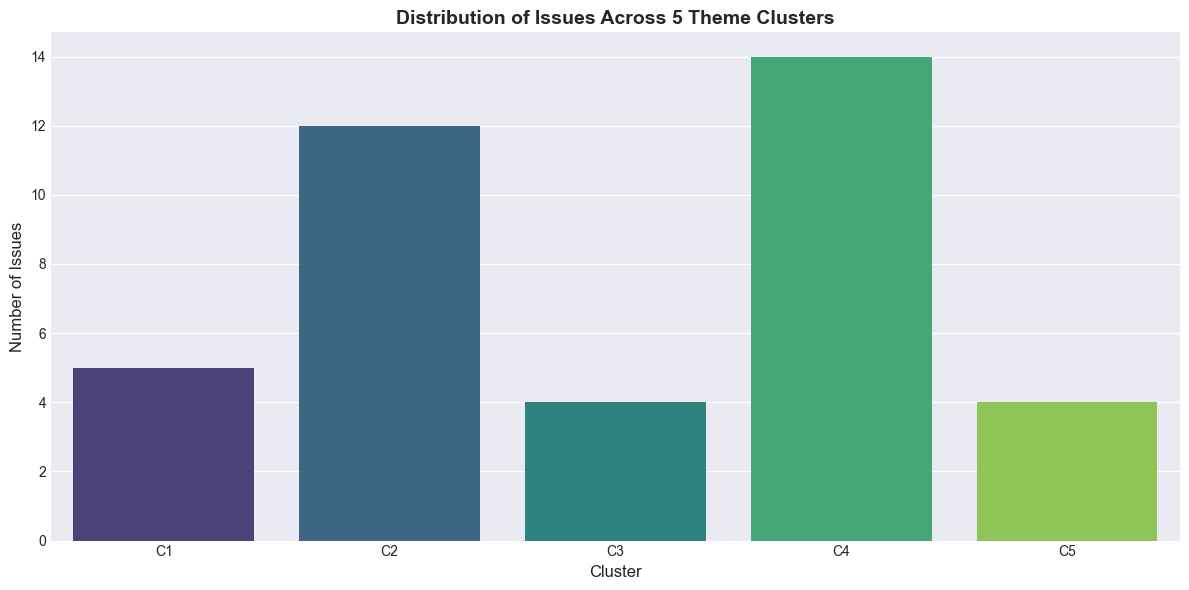

✅ Saved cluster visualization


In [23]:
# Cluster distribution
plt.figure(figsize=(12, 6))
cluster_counts = issues_with_themes['cluster'].value_counts().sort_index()

sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Number of Issues', fontsize=12)
plt.title('Distribution of Issues Across 5 Theme Clusters', fontsize=14, fontweight='bold')
plt.xticks(range(n_clusters), [f"C{i+1}" for i in range(n_clusters)])
plt.tight_layout()
plt.savefig('../reports/cluster_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved cluster visualization")

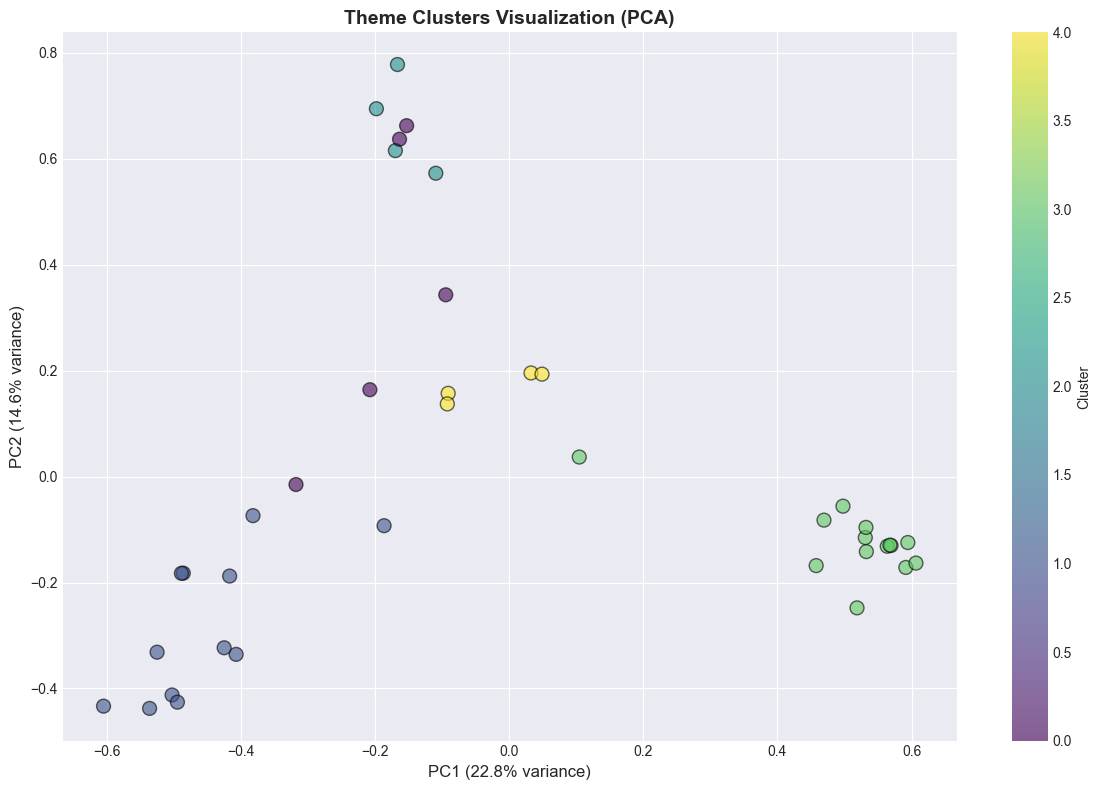

✅ Saved PCA visualization


In [24]:
# PCA visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X.toarray())

plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=cluster_labels,
    cmap='viridis',
    s=100,
    alpha=0.6,
    edgecolors='black'
)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
plt.title('Theme Clusters Visualization (PCA)', fontsize=14, fontweight='bold')
plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.savefig('../reports/cluster_pca_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved PCA visualization")

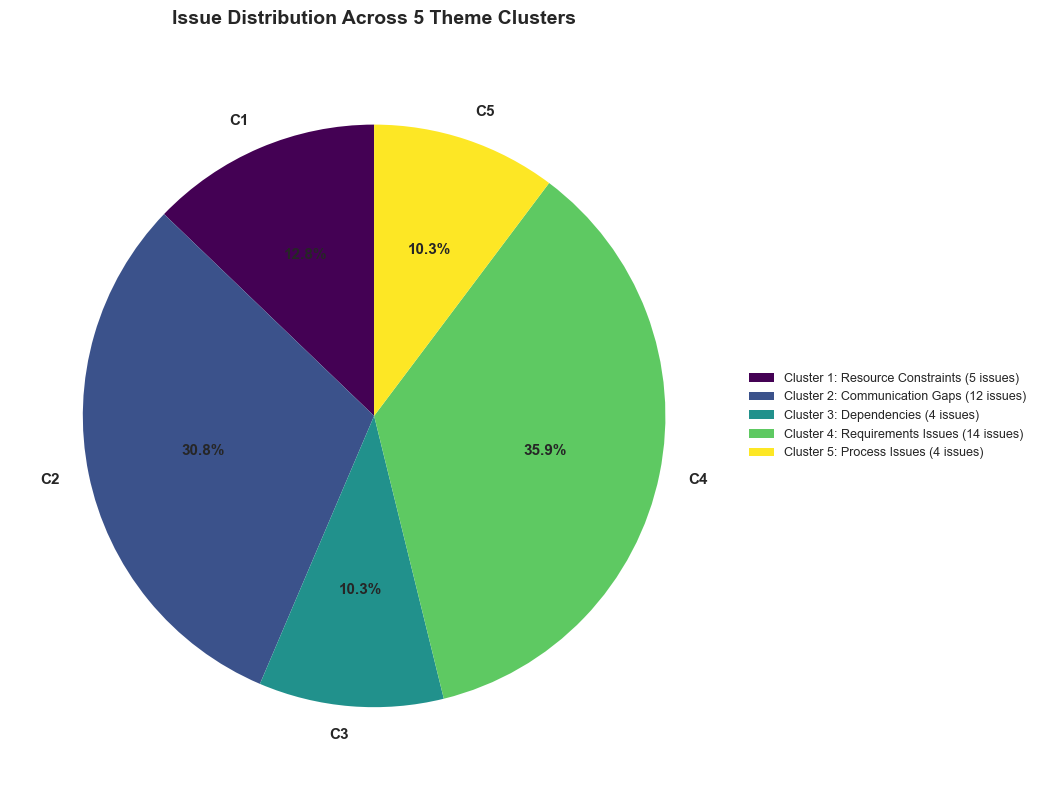

✅ Saved: viz_01_cluster_pie.png


In [28]:
# 1. Cluster Distribution Pie Chart
plt.figure(figsize=(10, 8))
cluster_counts = issues_with_themes['cluster'].value_counts().sort_index()
colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))

plt.pie(cluster_counts.values, 
        labels=[f"C{i+1}" for i in range(n_clusters)],
        autopct='%1.1f%%',
        colors=colors,
        startangle=90,
        textprops={'fontsize': 11, 'weight': 'bold'})

plt.title('Issue Distribution Across 5 Theme Clusters', fontsize=14, fontweight='bold', pad=20)

# Add legend with cluster names
legend_labels = [cluster_names[i] for i in range(n_clusters)]
plt.legend(legend_labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)

plt.tight_layout()
plt.savefig('../reports/viz_01_cluster_pie.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: viz_01_cluster_pie.png")

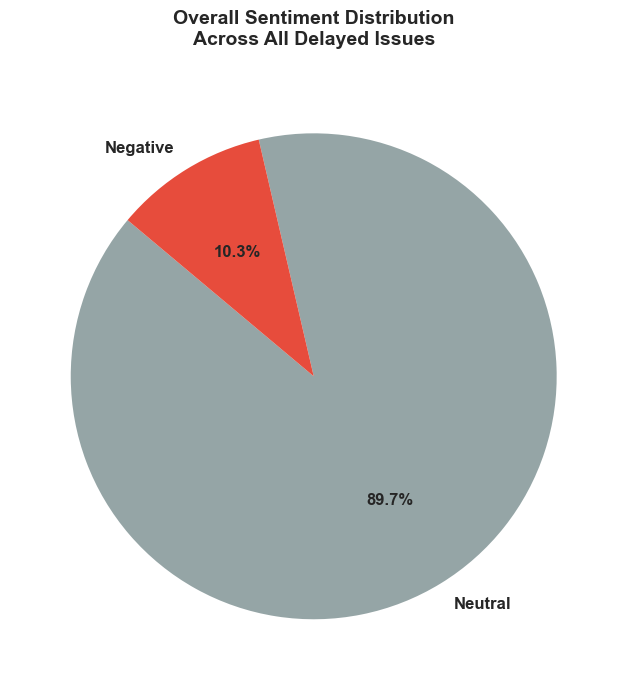

✅ Saved: viz_02_sentiment_pie.png


In [29]:
# 2. Sentiment Distribution Pie Chart
plt.figure(figsize=(10, 7))
sentiment_counts = issues_with_themes['sentiment'].value_counts()
colors_sentiment = {'negative': '#e74c3c', 'neutral': '#95a5a6', 'positive': '#2ecc71'}
pie_colors = [colors_sentiment.get(s, '#3498db') for s in sentiment_counts.index]

plt.pie(sentiment_counts.values,
        labels=[s.capitalize() for s in sentiment_counts.index],
        autopct='%1.1f%%',
        colors=pie_colors,
        startangle=140,
        textprops={'fontsize': 12, 'weight': 'bold'})

plt.title('Overall Sentiment Distribution\nAcross All Delayed Issues', 
          fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('../reports/viz_02_sentiment_pie.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: viz_02_sentiment_pie.png")

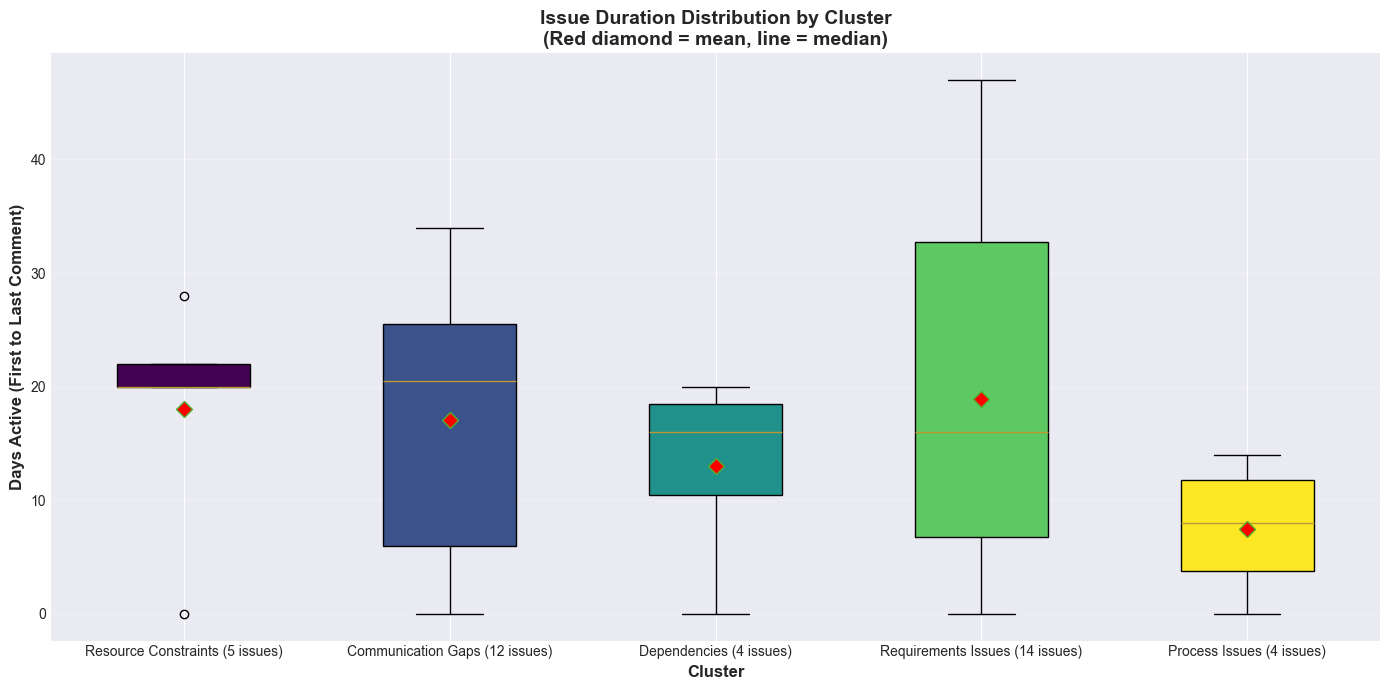

✅ Saved: viz_03_days_active_boxplot.png


In [ ]:
# 3. Days Active Distribution by Cluster (Box Plot)
plt.figure(figsize=(14, 7))

# Prepare data
cluster_days_data = [issues_with_themes[issues_with_themes['cluster'] == i]['days_active'].values 
                     for i in range(n_clusters)]

cluster_labels = [cluster_names[i].split(': ', 1)[1] if ': ' in cluster_names[i] else cluster_names[i] 
                  for i in range(n_clusters)]

bp = plt.boxplot(cluster_days_data, 
                 labels=cluster_labels, 
                 patch_artist=True,
                 showmeans=True,
                 meanprops=dict(marker='D', markerfacecolor='red', markersize=8))

# Color boxes
for patch, color in zip(bp['boxes'], plt.cm.viridis(np.linspace(0, 1, n_clusters))):
    patch.set_facecolor(color)

plt.xlabel('Cluster', fontsize=12, fontweight='bold')
plt.ylabel('Days Active (First to Last Comment)', fontsize=12, fontweight='bold')
plt.title('Issue Duration Distribution by Cluster\n(Red diamond = mean, line = median)', 
          fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/viz_03_days_active_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: viz_03_days_active_boxplot.png")

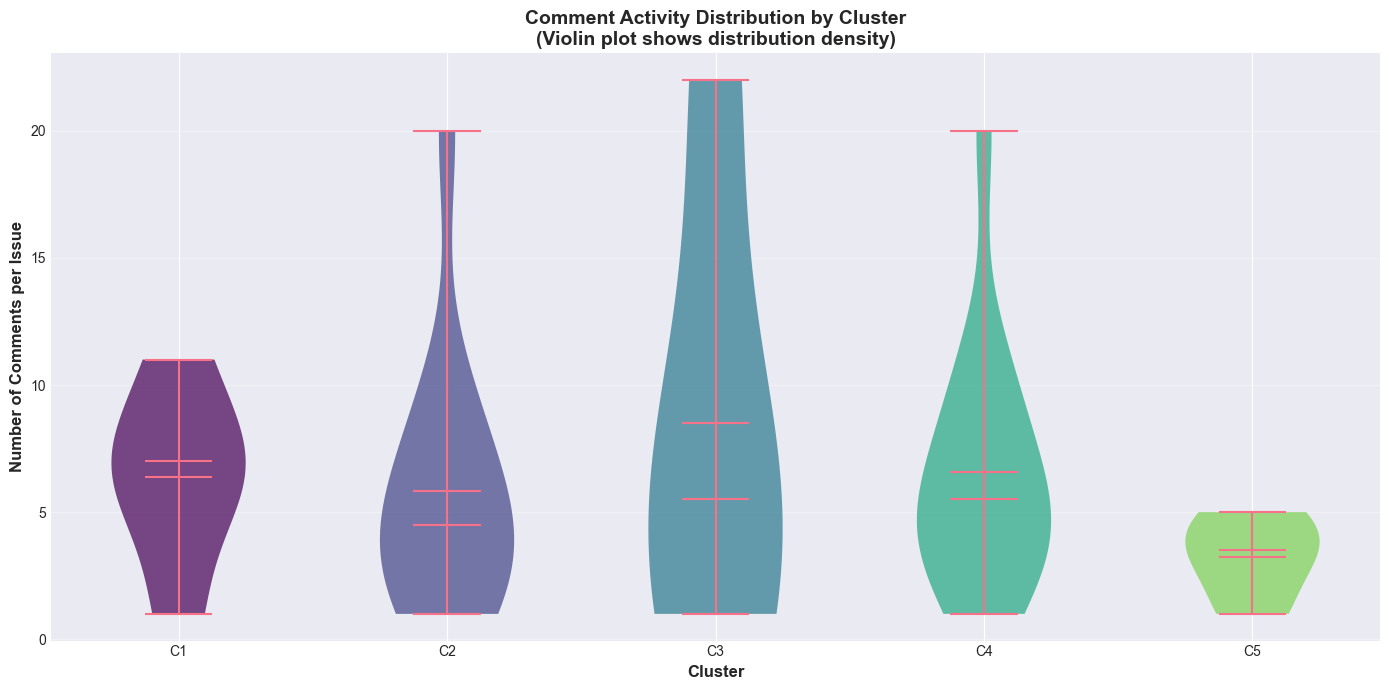

✅ Saved: viz_04_comments_violin.png


In [32]:
# 4. Comment Count Distribution by Cluster (Violin Plot)
plt.figure(figsize=(14, 7))

# Prepare data for violin plot
positions = range(n_clusters)
violin_data = [issues_with_themes[issues_with_themes['cluster'] == i]['comment_count'].values 
               for i in range(n_clusters)]

parts = plt.violinplot(violin_data, positions=positions, showmeans=True, showmedians=True)

# Color violins
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(plt.cm.viridis(i / n_clusters))
    pc.set_alpha(0.7)

plt.xlabel('Cluster', fontsize=12, fontweight='bold')
plt.ylabel('Number of Comments per Issue', fontsize=12, fontweight='bold')
plt.title('Comment Activity Distribution by Cluster\n(Violin plot shows distribution density)', 
          fontsize=14, fontweight='bold')
plt.xticks(positions, [f"C{i+1}" for i in range(n_clusters)])
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/viz_04_comments_violin.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: viz_04_comments_violin.png")

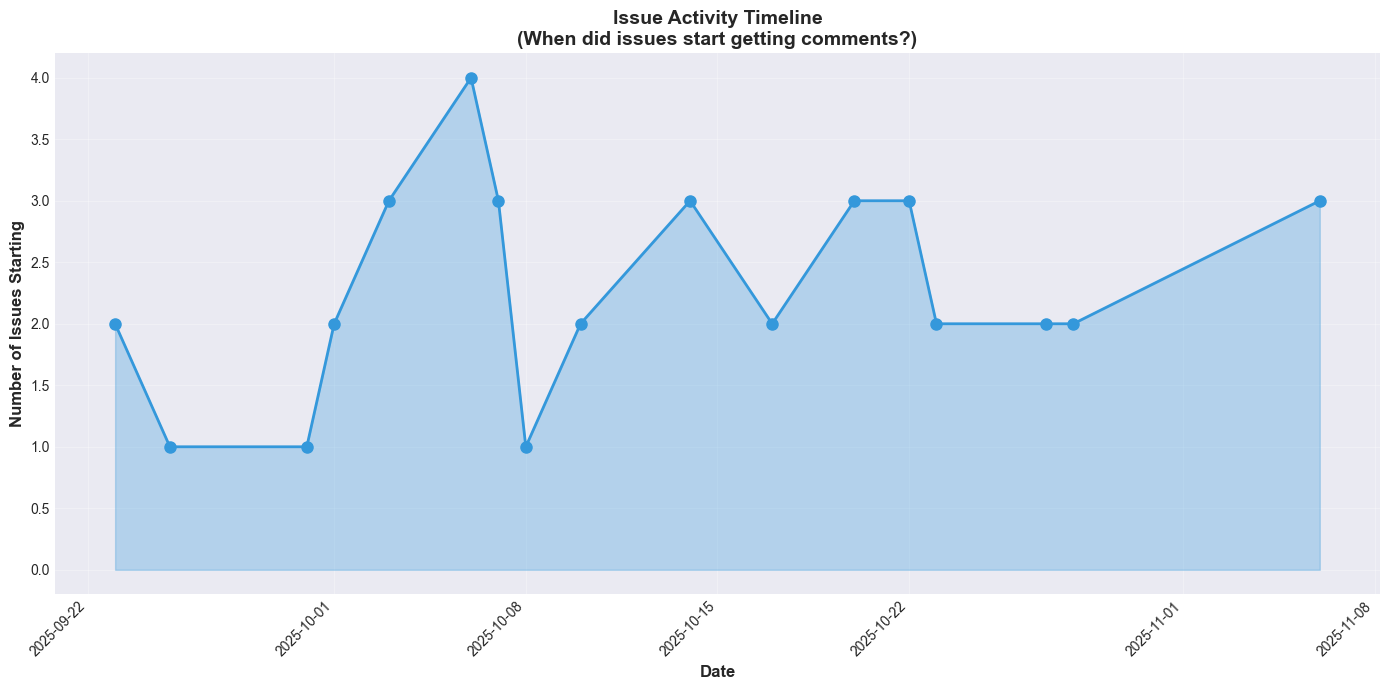

✅ Saved: viz_06_timeline.png


In [35]:
# 6. Timeline: Issue Activity Over Time
plt.figure(figsize=(14, 7))

# Handle timezone-aware datetime (convert to timezone-naive for plotting)
issues_with_themes['first_comment_date'] = pd.to_datetime(
    issues_with_themes['first_comment_date'], 
    utc=True
).dt.tz_localize(None)  # Remove timezone info for plotting

# Create timeline data
issues_with_themes_sorted = issues_with_themes.sort_values('first_comment_date')

# Count issues by date
date_counts = issues_with_themes_sorted.groupby(
    issues_with_themes_sorted['first_comment_date'].dt.date
).size()

plt.plot(date_counts.index, date_counts.values, 
         marker='o', linewidth=2, markersize=8, color='#3498db')

plt.fill_between(date_counts.index, date_counts.values, alpha=0.3, color='#3498db')

plt.xlabel('Date', fontsize=12, fontweight='bold')
plt.ylabel('Number of Issues Starting', fontsize=12, fontweight='bold')
plt.title('Issue Activity Timeline\n(When did issues start getting comments?)', 
          fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/viz_06_timeline.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: viz_06_timeline.png")

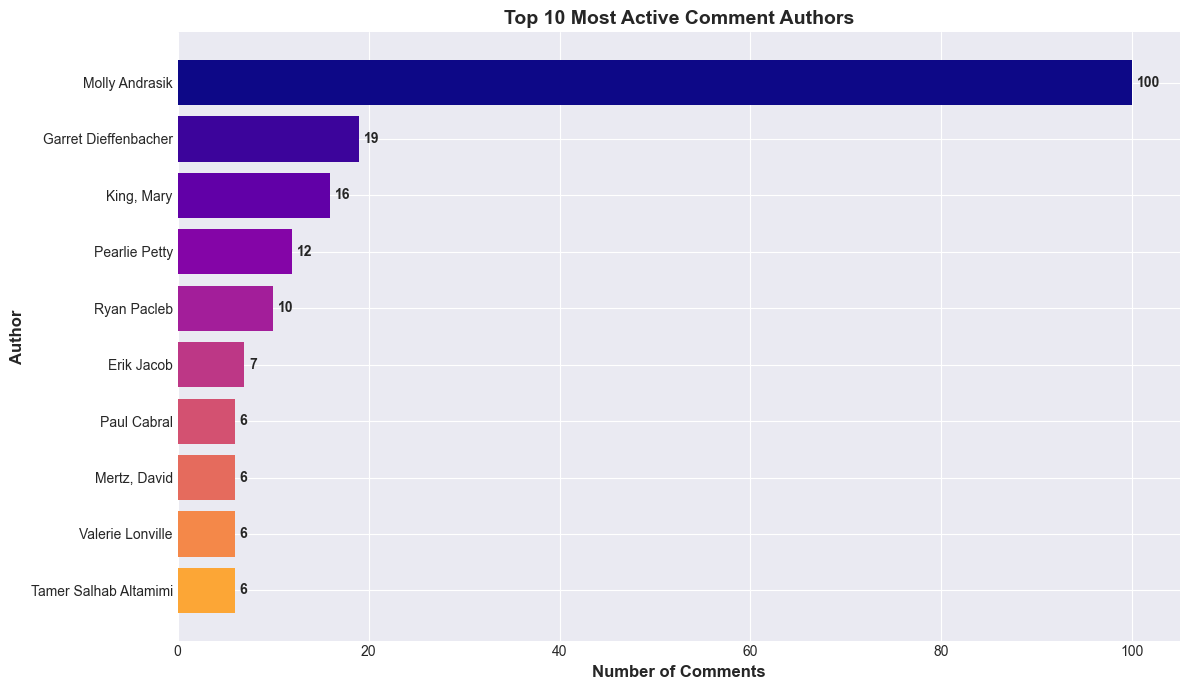

✅ Saved: viz_07_top_authors.png


In [36]:
# 7. Top 10 Most Active Authors
plt.figure(figsize=(12, 7))

# Count comments by author from original data
author_counts = issues_with_comments['Author'].value_counts().head(10)

colors = plt.cm.plasma(np.linspace(0, 0.8, len(author_counts)))
bars = plt.barh(range(len(author_counts)), author_counts.values, color=colors)

plt.yticks(range(len(author_counts)), author_counts.index)
plt.xlabel('Number of Comments', fontsize=12, fontweight='bold')
plt.ylabel('Author', fontsize=12, fontweight='bold')
plt.title('Top 10 Most Active Comment Authors', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()

# Add value labels
for i, (bar, value) in enumerate(zip(bars, author_counts.values)):
    plt.text(value + 0.5, i, str(value), va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/viz_07_top_authors.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: viz_07_top_authors.png")

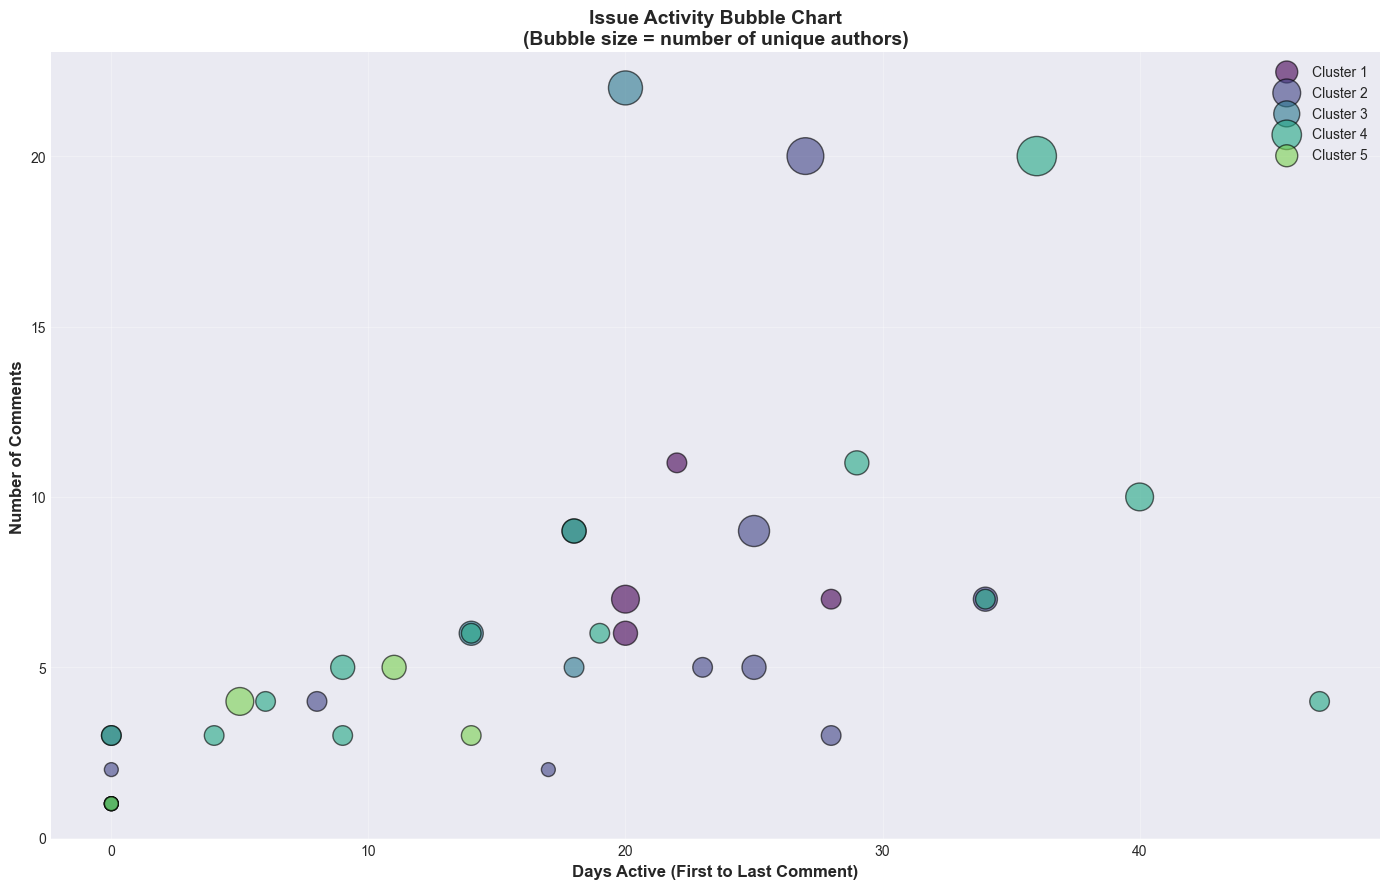

✅ Saved: viz_08_bubble_chart.png


In [37]:
# 8. Bubble Chart: Days Active vs Comment Count (sized by authors)
plt.figure(figsize=(14, 9))

# Create bubble chart
for cluster_id in range(n_clusters):
    cluster_data = issues_with_themes[issues_with_themes['cluster'] == cluster_id]
    
    plt.scatter(
        cluster_data['days_active'],
        cluster_data['comment_count'],
        s=cluster_data['unique_authors'] * 100,  # Size by unique authors
        alpha=0.6,
        c=[plt.cm.viridis(cluster_id / n_clusters)] * len(cluster_data),
        label=f"Cluster {cluster_id + 1}",
        edgecolors='black',
        linewidth=1
    )

plt.xlabel('Days Active (First to Last Comment)', fontsize=12, fontweight='bold')
plt.ylabel('Number of Comments', fontsize=12, fontweight='bold')
plt.title('Issue Activity Bubble Chart\n(Bubble size = number of unique authors)', 
          fontsize=14, fontweight='bold')
plt.legend(loc='upper right', fontsize=10)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/viz_08_bubble_chart.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: viz_08_bubble_chart.png")

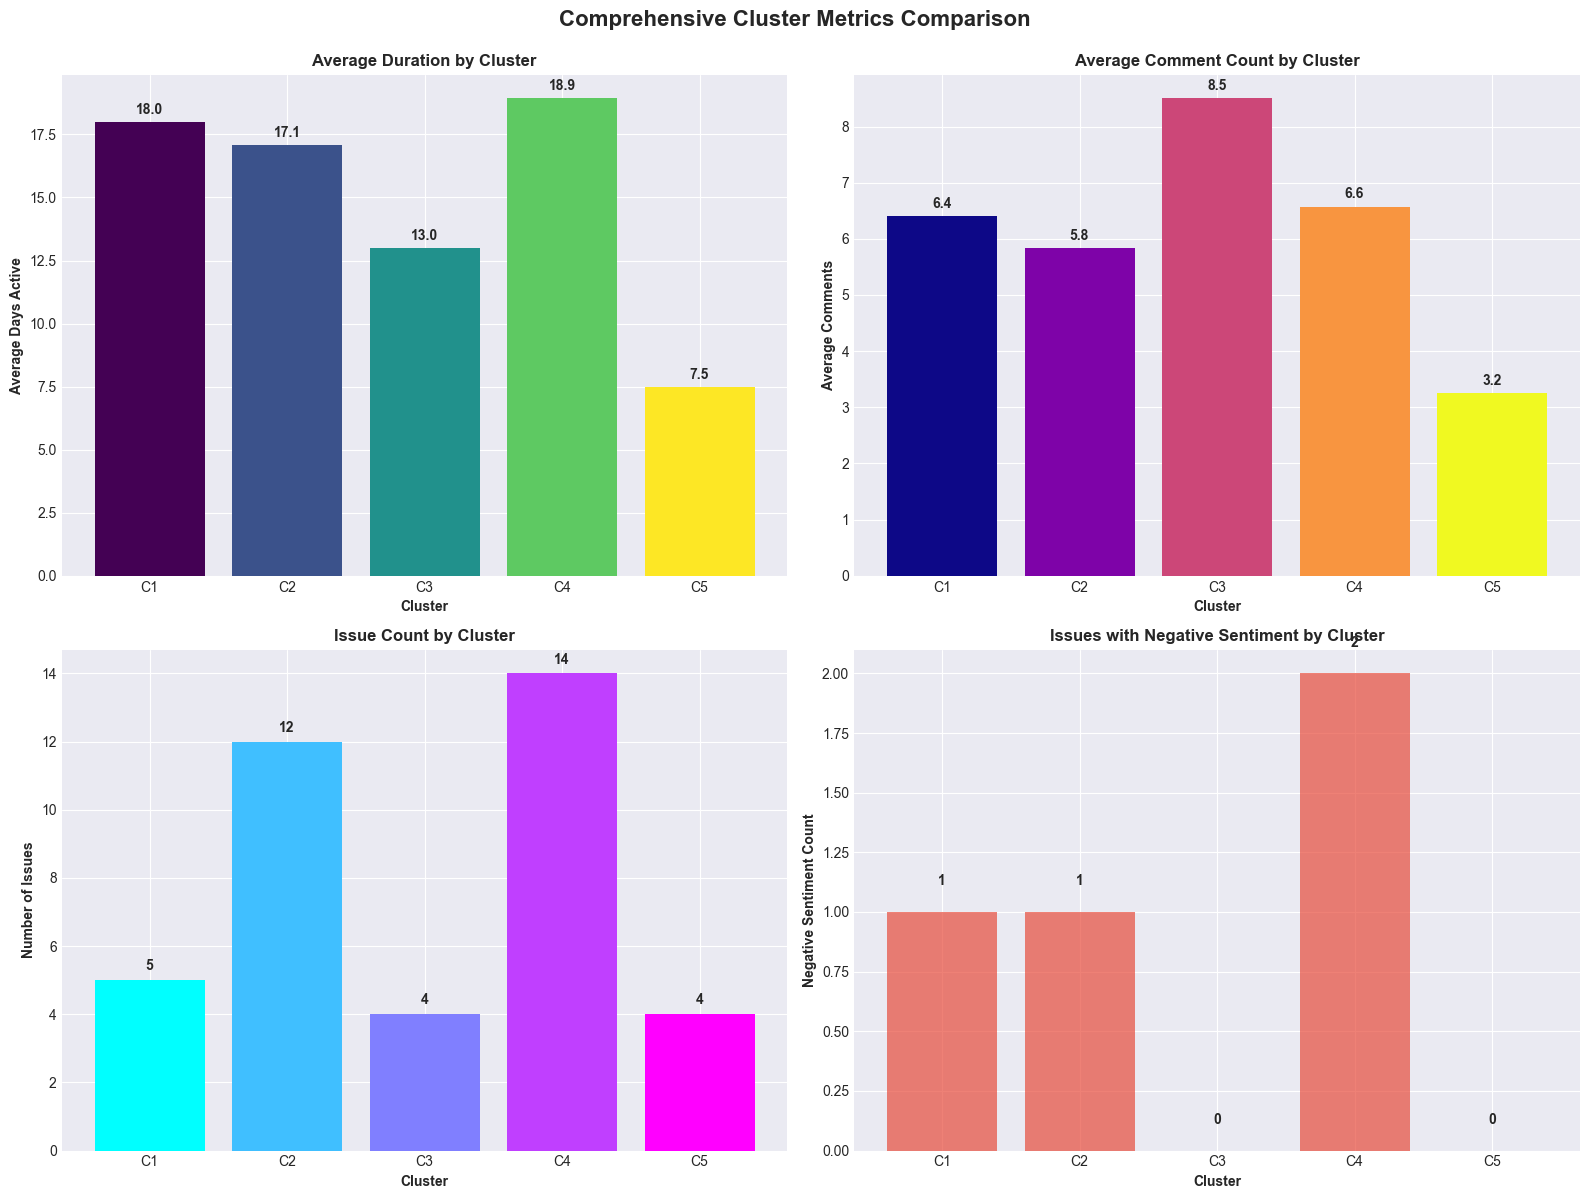

✅ Saved: viz_10_cluster_metrics_comparison.png


In [ ]:
cluster_labels = [cluster_names[i].split(': ', 1)[1] if ': ' in cluster_names[i] else cluster_names[i] 
                  for i in range(n_clusters)]

# 10. Cluster Metrics Comparison (Multi-metric bar chart)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))



# Metric 1: Average Days Active
ax1 = axes[0, 0]
avg_days = [issues_with_themes[issues_with_themes['cluster'] == i]['days_active'].mean() 
            for i in range(n_clusters)]
bars1 = ax1.bar(range(n_clusters), avg_days, color=plt.cm.viridis(np.linspace(0, 1, n_clusters)))
ax1.set_xlabel('Cluster', fontweight='bold')
ax1.set_ylabel('Average Days Active', fontweight='bold')
ax1.set_title('Average Duration by Cluster', fontweight='bold')
ax1.set_xticks(range(n_clusters))
ax1.set_xticklabels([f"C{i+1}" for i in range(n_clusters)])
for bar, val in zip(bars1, avg_days):
    ax1.text(bar.get_x() + bar.get_width()/2, val + 0.2, f'{val:.1f}', 
             ha='center', va='bottom', fontweight='bold')

# Metric 2: Average Comment Count
ax2 = axes[0, 1]
avg_comments = [issues_with_themes[issues_with_themes['cluster'] == i]['comment_count'].mean() 
                for i in range(n_clusters)]
bars2 = ax2.bar(range(n_clusters), avg_comments, color=plt.cm.plasma(np.linspace(0, 1, n_clusters)))
ax2.set_xlabel('Cluster', fontweight='bold')
ax2.set_ylabel('Average Comments', fontweight='bold')
ax2.set_title('Average Comment Count by Cluster', fontweight='bold')
ax2.set_xticks(range(n_clusters))
ax2.set_xticklabels([f"C{i+1}" for i in range(n_clusters)])
for bar, val in zip(bars2, avg_comments):
    ax2.text(bar.get_x() + bar.get_width()/2, val + 0.1, f'{val:.1f}', 
             ha='center', va='bottom', fontweight='bold')

# Metric 3: Issue Count
ax3 = axes[1, 0]
issue_counts = [len(issues_with_themes[issues_with_themes['cluster'] == i]) 
                for i in range(n_clusters)]
bars3 = ax3.bar(range(n_clusters), issue_counts, color=plt.cm.cool(np.linspace(0, 1, n_clusters)))
ax3.set_xlabel('Cluster', fontweight='bold')
ax3.set_ylabel('Number of Issues', fontweight='bold')
ax3.set_title('Issue Count by Cluster', fontweight='bold')
ax3.set_xticks(range(n_clusters))
ax3.set_xticklabels([f"C{i+1}" for i in range(n_clusters)])
for bar, val in zip(bars3, issue_counts):
    ax3.text(bar.get_x() + bar.get_width()/2, val + 0.2, str(val), 
             ha='center', va='bottom', fontweight='bold')

# Metric 4: Negative Sentiment Count
ax4 = axes[1, 1]
neg_counts = [(issues_with_themes[issues_with_themes['cluster'] == i]['sentiment'] == 'negative').sum() 
              for i in range(n_clusters)]
bars4 = ax4.bar(range(n_clusters), neg_counts, color='#e74c3c', alpha=0.7)
ax4.set_xlabel('Cluster', fontweight='bold')
ax4.set_ylabel('Negative Sentiment Count', fontweight='bold')
ax4.set_title('Issues with Negative Sentiment by Cluster', fontweight='bold')
ax4.set_xticks(range(n_clusters))
ax4.set_xticklabels([f"C{i+1}" for i in range(n_clusters)])
for bar, val in zip(bars4, neg_counts):
    ax4.text(bar.get_x() + bar.get_width()/2, val + 0.1, str(val), 
             ha='center', va='bottom', fontweight='bold')

plt.suptitle('Comprehensive Cluster Metrics Comparison', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('../reports/viz_10_cluster_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: viz_10_cluster_metrics_comparison.png")

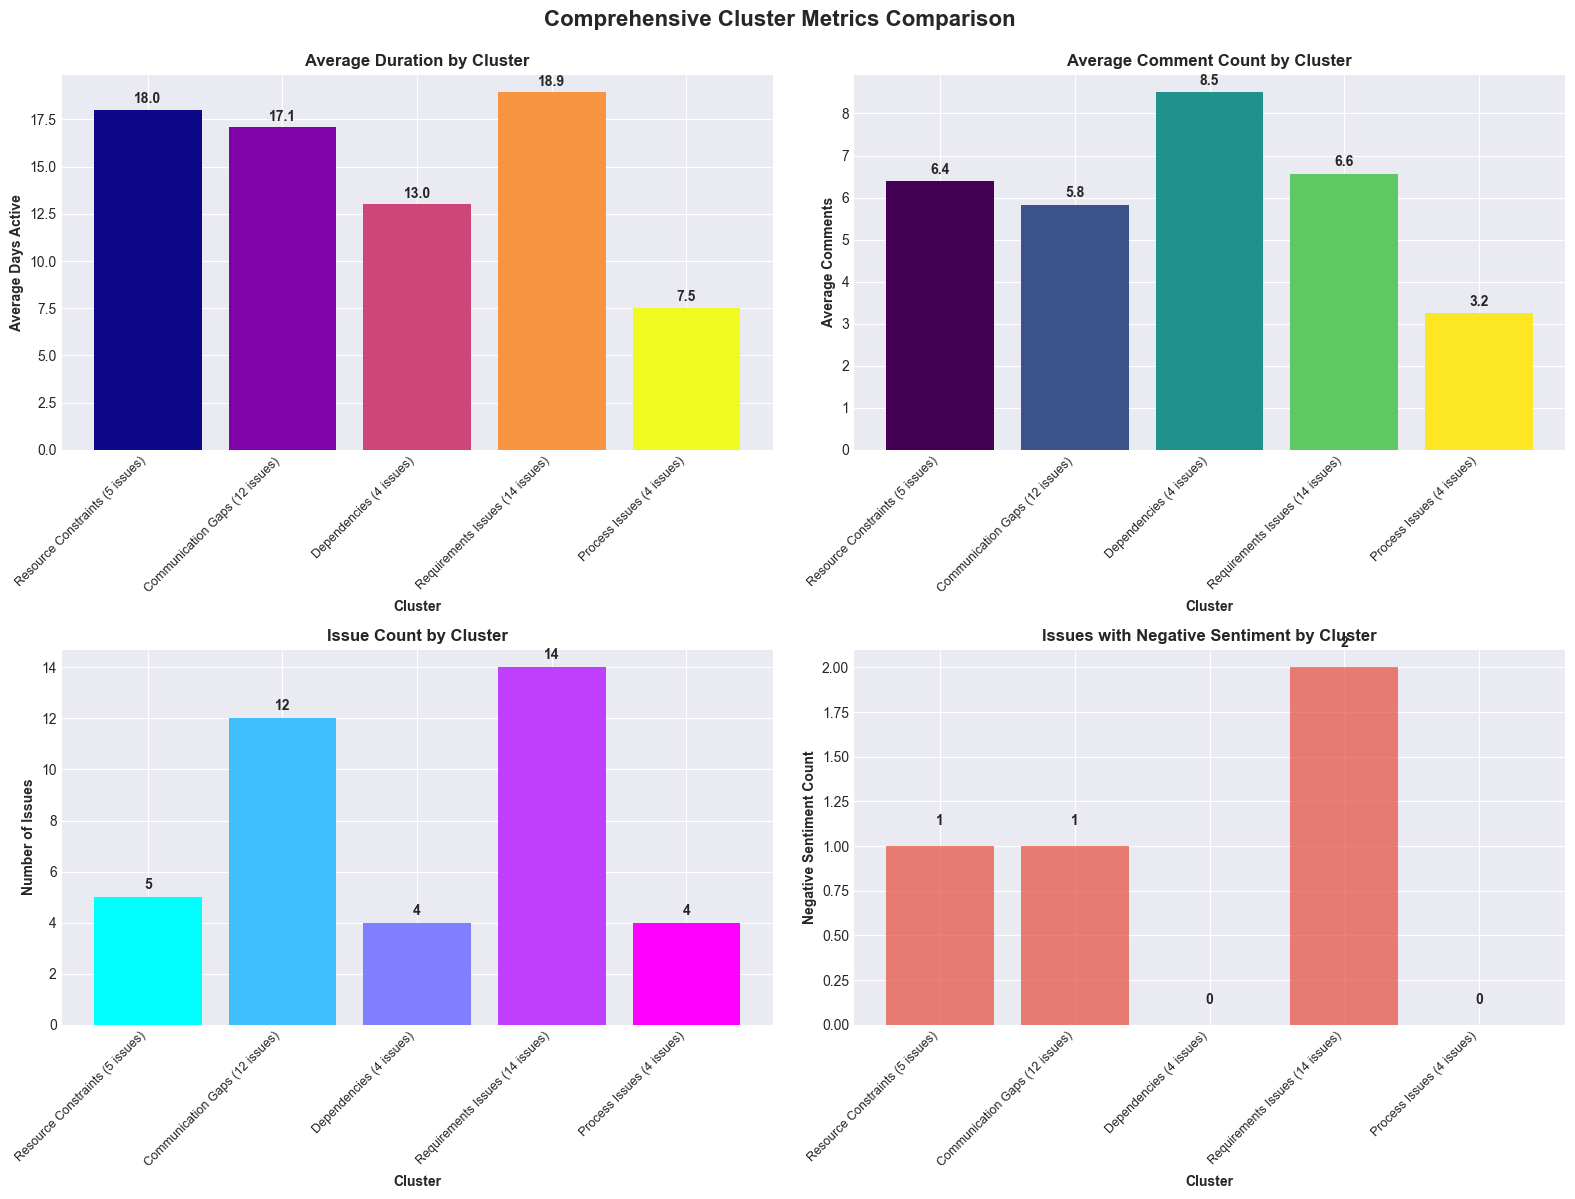

✅ Saved: viz_10_cluster_metrics_comparison.png


In [39]:
# 10. Cluster Metrics Comparison (Multi-metric bar chart)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Create short cluster labels (remove "Cluster X: " prefix)
cluster_labels_short = [cluster_names[i].split(': ', 1)[1] if ': ' in cluster_names[i] else cluster_names[i] 
                        for i in range(n_clusters)]

# Metric 1: Average Days Active
ax1 = axes[0, 0]
avg_days = [issues_with_themes[issues_with_themes['cluster'] == i]['days_active'].mean() 
            for i in range(n_clusters)]
bars1 = ax1.bar(range(n_clusters), avg_days, color=plt.cm.plasma(np.linspace(0, 1, n_clusters)))
ax1.set_xlabel('Cluster', fontweight='bold')
ax1.set_ylabel('Average Days Active', fontweight='bold')
ax1.set_title('Average Duration by Cluster', fontweight='bold')
ax1.set_xticks(range(n_clusters))
ax1.set_xticklabels(cluster_labels_short, rotation=45, ha='right', fontsize=9)
for bar, val in zip(bars1, avg_days):
    ax1.text(bar.get_x() + bar.get_width()/2, val + 0.2, f'{val:.1f}', 
             ha='center', va='bottom', fontweight='bold')

# Metric 2: Average Comment Count
ax2 = axes[0, 1]
avg_comments = [issues_with_themes[issues_with_themes['cluster'] == i]['comment_count'].mean() 
                for i in range(n_clusters)]
bars2 = ax2.bar(range(n_clusters), avg_comments, color=plt.cm.viridis(np.linspace(0, 1, n_clusters)))
ax2.set_xlabel('Cluster', fontweight='bold')
ax2.set_ylabel('Average Comments', fontweight='bold')
ax2.set_title('Average Comment Count by Cluster', fontweight='bold')
ax2.set_xticks(range(n_clusters))
ax2.set_xticklabels(cluster_labels_short, rotation=45, ha='right', fontsize=9)
for bar, val in zip(bars2, avg_comments):
    ax2.text(bar.get_x() + bar.get_width()/2, val + 0.1, f'{val:.1f}', 
             ha='center', va='bottom', fontweight='bold')

# Metric 3: Issue Count
ax3 = axes[1, 0]
issue_counts = [len(issues_with_themes[issues_with_themes['cluster'] == i]) 
                for i in range(n_clusters)]
bars3 = ax3.bar(range(n_clusters), issue_counts, color=plt.cm.cool(np.linspace(0, 1, n_clusters)))
ax3.set_xlabel('Cluster', fontweight='bold')
ax3.set_ylabel('Number of Issues', fontweight='bold')
ax3.set_title('Issue Count by Cluster', fontweight='bold')
ax3.set_xticks(range(n_clusters))
ax3.set_xticklabels(cluster_labels_short, rotation=45, ha='right', fontsize=9)
for bar, val in zip(bars3, issue_counts):
    ax3.text(bar.get_x() + bar.get_width()/2, val + 0.2, str(val), 
             ha='center', va='bottom', fontweight='bold')

# Metric 4: Negative Sentiment Count
ax4 = axes[1, 1]
neg_counts = [(issues_with_themes[issues_with_themes['cluster'] == i]['sentiment'] == 'negative').sum() 
              for i in range(n_clusters)]
bars4 = ax4.bar(range(n_clusters), neg_counts, color='#e74c3c', alpha=0.7)
ax4.set_xlabel('Cluster', fontweight='bold')
ax4.set_ylabel('Negative Sentiment Count', fontweight='bold')
ax4.set_title('Issues with Negative Sentiment by Cluster', fontweight='bold')
ax4.set_xticks(range(n_clusters))
ax4.set_xticklabels(cluster_labels_short, rotation=45, ha='right', fontsize=9)
for bar, val in zip(bars4, neg_counts):
    ax4.text(bar.get_x() + bar.get_width()/2, val + 0.1, str(val), 
             ha='center', va='bottom', fontweight='bold')

plt.suptitle('Comprehensive Cluster Metrics Comparison', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('../reports/viz_10_cluster_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: viz_10_cluster_metrics_comparison.png")

In [41]:
# Detailed reasoning analysis with wrapped text
import textwrap

print("\n" + "="*100)
print("CLUSTER REASONING ANALYSIS - DETAILED VIEW")
print("="*100)

for cluster_id in range(n_clusters):
    cluster_data = issues_with_themes[issues_with_themes['cluster'] == cluster_id]
    
    print(f"\n{'='*100}")
    print(f"CLUSTER {cluster_id + 1}: {cluster_names[cluster_id]}")
    print(f"{'='*100}")
    print(f"📊 Metrics: {len(cluster_data)} issues | Avg {cluster_data['days_active'].mean():.1f} days active | {cluster_data['comment_count'].mean():.1f} comments")
    print()
    
    # Show all issues in this cluster with reasoning
    for idx, row in cluster_data.iterrows():
        print(f"┌─ {row['IssueKey']} ─ {row['theme']}")
        print(f"│  📅 Days Active: {row['days_active']} | 💬 Comments: {row['comment_count']} | 👥 Authors: {row['unique_authors']}")
        print(f"│  😊 Sentiment: {row['sentiment'].upper()}")
        
        # Wrap the reasoning text to 90 characters
        wrapped_reasoning = textwrap.fill(row['reasoning'], width=90, initial_indent='│  📝 ', subsequent_indent='│     ')
        print(wrapped_reasoning)
        print("└" + "─" * 98)
        print()

print("="*100)
print("✅ Reasoning analysis complete!")


CLUSTER REASONING ANALYSIS - DETAILED VIEW

CLUSTER 1: Cluster 1: Resource Constraints (5 issues)
📊 Metrics: 5 issues | Avg 18.0 days active | 6.4 comments

┌─ SWIFT-6889 ─ Resource Constraints
│  📅 Days Active: 22 | 💬 Comments: 11 | 👥 Authors: 2
│  😊 Sentiment: NEGATIVE
│  📝 The primary issue causing the delay was the lack of assigned resources to the Design
│     task, as highlighted by multiple comments requesting status updates and noting the
│     absence of a resource assignment.
└──────────────────────────────────────────────────────────────────────────────────────────────────

┌─ SWIFT-6922 ─ Dependencies
│  📅 Days Active: 20 | 💬 Comments: 6 | 👥 Authors: 3
│  😊 Sentiment: NEUTRAL
│  📝 The delay is primarily due to waiting for data entry completion by Stephanie's team,
│     which is a task dependent on another team's actions.
└──────────────────────────────────────────────────────────────────────────────────────────────────

┌─ SWIFT-6932 ─ Dependencies
│  📅 Days Active: 20 | 

## 10. Export Results

Generate final PDF report with cluster reasoning analysis.

In [ ]:
# !pip install reportlab

# Export reasoning analysis to PDF
from reportlab.lib.pagesizes import letter, A4
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.units import inch
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, PageBreak, Table, TableStyle
from reportlab.lib import colors
from reportlab.lib.enums import TA_LEFT, TA_CENTER
import textwrap

# Create PDF
pdf_filename = '../reports/cluster_reasoning_analysis.pdf'
doc = SimpleDocTemplate(pdf_filename, pagesize=letter, topMargin=0.75*inch, bottomMargin=0.75*inch)
story = []

# Styles
styles = getSampleStyleSheet()
title_style = ParagraphStyle(
    'CustomTitle',
    parent=styles['Heading1'],
    fontSize=18,
    textColor=colors.HexColor('#2c3e50'),
    spaceAfter=30,
    alignment=TA_CENTER
)
heading_style = ParagraphStyle(
    'CustomHeading',
    parent=styles['Heading2'],
    fontSize=14,
    textColor=colors.HexColor('#34495e'),
    spaceAfter=12,
    spaceBefore=12
)
normal_style = styles['Normal']

# Title
story.append(Paragraph("JIRA Delay Analysis - Cluster Reasoning Report", title_style))
story.append(Paragraph(f"Analysis Period: October 2025", normal_style))
story.append(Paragraph(f"Total Issues Analyzed: {len(issues_with_themes)}", normal_style))
story.append(Spacer(1, 0.3*inch))

# Add each cluster
for cluster_id in range(n_clusters):
    cluster_data = issues_with_themes[issues_with_themes['cluster'] == cluster_id]
    
    # Cluster header
    story.append(Paragraph(f"CLUSTER {cluster_id + 1}: {cluster_names[cluster_id]}", heading_style))
    
    # Metrics summary
    metrics_text = f"<b>Metrics:</b> {len(cluster_data)} issues | Avg {cluster_data['days_active'].mean():.1f} days active | {cluster_data['comment_count'].mean():.1f} comments"
    story.append(Paragraph(metrics_text, normal_style))
    story.append(Spacer(1, 0.15*inch))
    
    # Create table for issues
    table_data = [['IssueKey', 'Theme', 'Days', 'Comments', 'Sentiment', 'Reasoning']]
    
    for idx, row in cluster_data.iterrows():
        # Wrap reasoning text
        wrapped_reasoning = textwrap.fill(row['reasoning'], width=40)
        
        table_data.append([
            row['IssueKey'],
            textwrap.fill(row['theme'], width=20),
            str(row['days_active']),
            str(row['comment_count']),
            row['sentiment'],
            wrapped_reasoning
        ])
    
    # Create table
    t = Table(table_data, colWidths=[1*inch, 1.5*inch, 0.6*inch, 0.7*inch, 0.7*inch, 2.5*inch])
    t.setStyle(TableStyle([
        ('BACKGROUND', (0, 0), (-1, 0), colors.HexColor('#3498db')),
        ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
        ('ALIGN', (0, 0), (-1, -1), 'LEFT'),
        ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
        ('FONTSIZE', (0, 0), (-1, 0), 10),
        ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
        ('BACKGROUND', (0, 1), (-1, -1), colors.beige),
        ('GRID', (0, 0), (-1, -1), 1, colors.black),
        ('VALIGN', (0, 0), (-1, -1), 'TOP'),
        ('FONTSIZE', (0, 1), (-1, -1), 8),
    ]))
    
    story.append(t)
    story.append(PageBreak())

# Build PDF
doc.build(story)
print(f"✅ PDF exported to: {pdf_filename}")


   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/2.0 MB ? eta -:--:--
   ---------------- ----------------------- 0.8/2.0 MB 1.3 MB/s eta 0:00:01
   --------------------- ------------------ 1.0/2.0 MB 1.4 MB/s eta 0:00:01
   -------------------------- ------------- 1.3/2.0 MB 1.5 MB/s eta 0:00:01
   ------------------------------------- -- 1.8/2.0 MB 1.6 MB/s eta 0:00:01
   ---------------------------------------- 2.0/2.0 MB 1.6 MB/s  0:00:01
✅ PDF exported to: ../reports/cluster_reasoning_analysis.pdf
